### OpenCV DNN 패키지를 이용하여 SSD 기반 Object Detection 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행. 

#### 입력 이미지로 사용될 이미지 보기

image shape: (633, 806, 3)


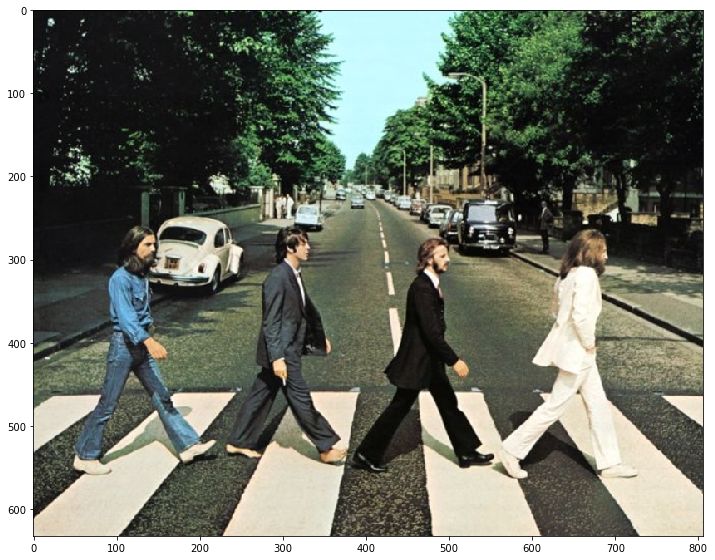

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('../../data/image/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt 에서 다운로드 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 


In [ ]:
# mkdir pretrained; cd pretrained
# wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
# wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
# cd ssd_inception_v2_coco_2017_11_17; mv ssd_inception_v2_coco_2017_11_17.pbtxt graph.pbtxt
# https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt?raw=true -O ./graph.pbtxt

In [2]:
!pwd
!ls pretrained/ssd_inception_v2_coco_2017_11_17

/home/younggi.kim999/DLCV/Detection/ssd
checkpoint		   model.ckpt.data-00000-of-00001  saved_model
frozen_inference_graph.pb  model.ckpt.index
graph.pbtxt		   model.ckpt.meta


In [3]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 
                                     './pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt')

#### coco 데이터 세트의 클래스id별 클래스명 지정. 

In [ ]:
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화 

(1, 1, 100, 7)
person: 0.9696 1
person: 0.9660 1
person: 0.8916 1
person: 0.6298 1
car: 0.8609 3
car: 0.7223 3
car: 0.7184 3
car: 0.7095 3
car: 0.5949 3
car: 0.5511 3


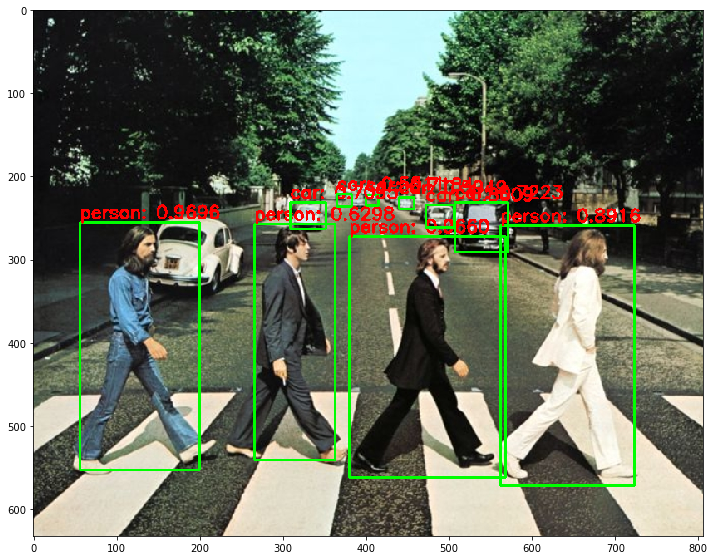

In [6]:
# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.4 이상만 추출
    if score > 0.4:
        # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
        
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
        print(caption, class_id)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection을 함수로 생성

In [ ]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.4 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

In [ ]:
# image 로드 
img = cv2.imread('../../data/image/john_wick01.jpg')

#coco dataset 클래스명 매핑

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 
                                     './pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt')
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### Video Object Detection 수행

#### 원본 영상 보기

In [ ]:
from IPython.display import clear_output, Image, display, Video, HTML
Video('../../data/video/John_Wick_small.mp4')

#### VideoCapture와 VideoWriter 설정하기
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정. 
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정 

##### 총 Frame 별로 iteration 하면서 Object Detection 수행. 개별 frame별로 단일 이미지 Object Detection과 유사 

#### video detection 전용 함수 생성. 

In [ ]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=True, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [ ]:
do_detected_video(cv_net, '../../data/video/John_Wick_small.mp4', '../../data/output/John_Wick_small_ssd01.avi', 0.4, True)

In [ ]:
!gsutil cp ../../data/output/John_Wick_small_ssd01.avi gs://my_bucket_dlcv/data/output/John_Wick_small_ssd01.avi

### SSD+Mobilenet으로 Object Detection 수행. 
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음. 
* weight파일은 http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz 에서 다운로드

In [ ]:
# !mkdir pretrained; cd pretrained
# !wget  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
# !wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_mobilenet_v2_coco_2018_03_29.pbtxt
# cd ssd_mobilenet_v2_coco_2018_03_29; mv ssd_mobilenet_v2_coco_2018_03_29.pbtxt graph.pbtxt

In [ ]:
cv_net_mobile = cv2.dnn.readNetFromTensorflow('./pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 
                                     './pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt')

#### 영상 Detection

In [ ]:
do_detected_video(cv_net_mobile, '../../data/video/John_Wick_small.mp4', '../../data/output/John_Wick_small_ssd_mobile01.avi', 0.2, True)

In [ ]:
!gsutil cp ../../data/output/John_Wick_small_ssd_mobile01.avi gs://my_bucket_dlcv/data/output/John_Wick_small_ssd_mobile01.avi

In [ ]:
# image 로드 
img = cv2.imread('../../data/image/beatles01.jpg')

#coco dataset 클래스명 매핑

cv_net_mobile = cv2.dnn.readNetFromTensorflow('./pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 
                                     './pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt')
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_mobile, img, score_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)